# Download Data into local for 1Q

In [1]:
import os
import requests
from tqdm import tqdm
import pandas as pd

# Create directory for data if it doesn't exist
os.makedirs('nyc_taxi_data', exist_ok=True)

def download_file(url, local_filename):
    """
    Download a file from a URL with a progress bar
    """
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        
        with open(local_filename, 'wb') as f, tqdm(
                total=total_size,
                unit='B',
                unit_scale=True,
                unit_divisor=1024,
                desc=local_filename
            ) as progress_bar:
            
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                progress_bar.update(len(chunk))
    
    return local_filename

# Define the time period for the data (e.g., 2022, first quarter)
year = 2022
months = [1, 2, 3]  # January, February, March

# Base URL for the NYC TLC data
base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data"

# Download Yellow Taxi data
for month in months:
    # Format month with leading zero
    month_str = f"{month:02d}"
    
    # Construct the URL and filename for Yellow taxi data
    filename = f"yellow_tripdata_{year}-{month_str}.parquet"
    url = f"{base_url}/{filename}"
    local_path = os.path.join('nyc_taxi_data', filename)
    
    print(f"Downloading {filename}...")
    try:
        download_file(url, local_path)
        print(f"Successfully downloaded {filename}")
    except Exception as e:
        print(f"Failed to download {filename}: {e}")

# Print summary
print("\nDownload Summary:")
print(f"Data saved to: {os.path.abspath('nyc_taxi_data')}")
print(f"Downloaded data for year {year}, months: {', '.join([str(m) for m in months])}")

# Quick verification of downloaded files
for month in months:
    month_str = f"{month:02d}"
    filename = f"yellow_tripdata_{year}-{month_str}.parquet"
    file_path = os.path.join('nyc_taxi_data', filename)
    
    if os.path.exists(file_path):
        # Get file size in MB
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"{filename}: {size_mb:.2f} MB")
        
        # Read the first few rows to verify the file structure
        try:
            df = pd.read_parquet(file_path)
            print(f"  Rows: {len(df)}, Columns: {len(df.columns)}")
            print(f"  First few columns: {', '.join(df.columns[:5])}")
        except Exception as e:
            print(f"  Error reading file: {e}")
    else:
        print(f"{filename}: Not found")

nyc_taxi_data/yellow_tripdata_2022-01.parquet: 100%|██████████| 36.4M/36.4M [00:00<00:00, 319MB/s]

Successfully downloaded yellow_tripdata_2022-01.parquet



nyc_taxi_data/yellow_tripdata_2022-02.parquet: 100%|██████████| 43.5M/43.5M [00:00<00:00, 379MB/s]


Successfully downloaded yellow_tripdata_2022-02.parquet


nyc_taxi_data/yellow_tripdata_2022-03.parquet: 100%|██████████| 53.1M/53.1M [00:00<00:00, 390MB/s]


Successfully downloaded yellow_tripdata_2022-03.parquet

Download Summary:
Data saved to: /expanse/lustre/projects/uci150/rvasappanavara/shared/nyc_taxi_data
Downloaded data for year 2022, months: 1, 2, 3
yellow_tripdata_2022-01.parquet: 36.37 MB
  Rows: 2463931, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2022-02.parquet: 43.50 MB
  Rows: 2979431, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2022-03.parquet: 53.10 MB
  Rows: 3627882, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


# Set Up Spark Environment

In [11]:
# First, create the Spark session with optimized configuration
from pyspark.sql import SparkSession

# Create Spark session first
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

from pyspark.sql.functions import (
    hour as hour_func,
    dayofweek as dayofweek_func,
    month as month_func,
    year as year_func,
    to_date as to_date_func,
    when as when_func,
    col,  # Regular col without renaming
    unix_timestamp as unix_timestamp_func,
    avg as avg_func
)

# Import other required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

print("Imports completed successfully")

Imports completed successfully


# Loading and Exploring the NYC Taxi Data

In [12]:
# Path to the downloaded data
data_path = "nyc_taxi_data/"  # Adjust this path to where you stored the data
year = 2022
month = 1  # January

# Construct the file path
file_path = f"{data_path}yellow_tripdata_{year}-{month:02d}.parquet"

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")
    print(f"Current working directory: {os.getcwd()}")
    print("Please check the file path and try again.")

# Load the Parquet file into a Spark DataFrame
try:
    taxi_df = spark.read.parquet(file_path)
    print(f"Successfully loaded data with {taxi_df.count()} records and {len(taxi_df.columns)} columns")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    
# Display schema
print("\nDataset Schema:")
taxi_df.printSchema()

# Show a sample of the data
print("\nSample Data:")
taxi_df.show(5)

File found: nyc_taxi_data/yellow_tripdata_2022-01.parquet
Successfully loaded data with 2463931 records and 19 columns

Dataset Schema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = t

# Understanding the Data Structure

In [13]:
# Path to the downloaded data
data_path = "nyc_taxi_data/"  # Adjust this path to where you stored the data
year = 2022
month = 1  # January

# Construct the file path
file_path = f"{data_path}yellow_tripdata_{year}-{month:02d}.parquet"

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")
    print(f"Current working directory: {os.getcwd()}")
    print("Please check the file path and try again.")

# Load the Parquet file into a Spark DataFrame
try:
    taxi_df = spark.read.parquet(file_path)
    print(f"Successfully loaded data with {taxi_df.count()} records and {len(taxi_df.columns)} columns")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    
# Display schema
print("\nDataset Schema:")
taxi_df.printSchema()

# Show a sample of the data
print("\nSample Data:")
taxi_df.show(5)

File found: nyc_taxi_data/yellow_tripdata_2022-01.parquet
Successfully loaded data with 2463931 records and 19 columns

Dataset Schema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = t

# Creating Features for EDA

In [14]:
# Add temporal features
enhanced_df = taxi_df.withColumn("pickup_hour", hour_func("tpep_pickup_datetime")) \
    .withColumn("pickup_day", dayofweek_func("tpep_pickup_datetime")) \
    .withColumn("pickup_month", month_func("tpep_pickup_datetime")) \
    .withColumn("pickup_year", year_func("tpep_pickup_datetime")) \
    .withColumn("pickup_date", to_date_func("tpep_pickup_datetime")) \
    .withColumn("is_weekend", when_func(dayofweek_func("tpep_pickup_datetime").isin([1, 7]), True).otherwise(False)) \
    .withColumn("trip_duration_minutes", 
                (unix_timestamp_func("tpep_dropoff_datetime") - unix_timestamp_func("tpep_pickup_datetime")) / 60) \
    .withColumn("time_of_day", 
               when_func((hour_func("tpep_pickup_datetime") >= 6) & (hour_func("tpep_pickup_datetime") < 12), "Morning")
               .when((hour_func("tpep_pickup_datetime") >= 12) & (hour_func("tpep_pickup_datetime") < 18), "Afternoon")
               .when((hour_func("tpep_pickup_datetime") >= 18) & (hour_func("tpep_pickup_datetime") < 22), "Evening")
               .otherwise("Night")) \
    .withColumn("speed_mph", when_func(col_func("trip_duration_minutes") > 0, 
                                 col_func("trip_distance") / (col_func("trip_duration_minutes") / 60)).otherwise(0)) \
    .withColumn("tip_percentage", when_func(col_func("fare_amount") > 0, 
                                      (col_func("tip_amount") / col_func("fare_amount")) * 100).otherwise(0))

# Clean the data by filtering out extreme values
cleaned_df = enhanced_df.filter(
    (col("trip_distance") > 0) & (col("trip_distance") < 100) &
    (col("fare_amount") > 0) & (col("fare_amount") < 1000) &
    (col("passenger_count") > 0) & (col("passenger_count") < 10) &
    (col("trip_duration_minutes") > 0) & (col("trip_duration_minutes") < 180) &
    (col("speed_mph") < 100)  # Reasonable speed limit
)

# Check data size after cleaning
original_count = taxi_df.count()
cleaned_count = cleaned_df.count()
removed_percentage = ((original_count - cleaned_count) / original_count) * 100

print(f"Original dataset: {original_count} records")
print(f"Cleaned dataset: {cleaned_count} records")
print(f"Removed {original_count - cleaned_count} records ({removed_percentage:.2f}%)")

# Show the enhanced dataset
print("\nEnhanced Dataset Sample:")
cleaned_df.select("tpep_pickup_datetime", "pickup_hour", "time_of_day", "is_weekend", 
                 "trip_distance", "trip_duration_minutes", "speed_mph", 
                 "fare_amount", "tip_amount", "tip_percentage").show(5)

Original dataset: 2463931 records
Cleaned dataset: 2297632 records
Removed 166299 records (6.75%)

Enhanced Dataset Sample:
+--------------------+-----------+-----------+----------+-------------+---------------------+------------------+-----------+----------+------------------+
|tpep_pickup_datetime|pickup_hour|time_of_day|is_weekend|trip_distance|trip_duration_minutes|         speed_mph|fare_amount|tip_amount|    tip_percentage|
+--------------------+-----------+-----------+----------+-------------+---------------------+------------------+-----------+----------+------------------+
| 2022-01-01 00:35:40|          0|      Night|      true|          3.8|   17.816666666666666|12.797006548175863|       14.5|      3.65| 25.17241379310345|
| 2022-01-01 00:33:43|          0|      Night|      true|          2.1|                  8.4|              15.0|        8.0|       4.0|              50.0|
| 2022-01-01 00:53:21|          0|      Night|      true|         0.97|    8.966666666666667|6.490706

# Basic Statistics and Data Quality Insights

In [15]:
# Check data size after cleaning
original_count = taxi_df.count()
enhanced_count = enhanced_df.count()
cleaned_count = cleaned_df.count()

print(f"Original dataset: {original_count} records")
print(f"Enhanced dataset: {enhanced_count} records")
print(f"Cleaned dataset: {cleaned_count} records")
print(f"Removed {original_count - cleaned_count} records ({(original_count - cleaned_count) / original_count * 100:.2f}%)")

# Basic statistics for key numeric columns
numeric_columns = ["trip_distance", "fare_amount", "tip_amount", "trip_duration_minutes", 
                   "speed_mph", "tip_percentage", "passenger_count"]

print("\nBasic Statistics for Key Metrics:")
cleaned_df.select(numeric_columns).summary("count", "min", "25%", "mean", "50%", "75%", "max").show()

Original dataset: 2463931 records
Enhanced dataset: 2463931 records
Cleaned dataset: 2297632 records
Removed 166299 records (6.75%)

Basic Statistics for Key Metrics:
+-------+------------------+------------------+------------------+---------------------+--------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|        tip_amount|trip_duration_minutes|           speed_mph|    tip_percentage|   passenger_count|
+-------+------------------+------------------+------------------+---------------------+--------------------+------------------+------------------+
|  count|           2297632|           2297632|           2297632|              2297632|             2297632|           2297632|           2297632|
|    min|              0.01|              0.01|               0.0| 0.016666666666666666|0.003899057727715802|               0.0|               1.0|
|    25%|              1.07|               6.5|               1.0|    6.383333333333334|   8.

# Register a Temporary View for SQL-Based Analysis

In [16]:
# Register the dataframe as a temporary view for SQL analysis
cleaned_df.createOrReplaceTempView("nyc_taxi")

# Basic count by time of day
print("\nTrip Distribution by Time of Day:")
spark.sql("""
    SELECT 
        time_of_day,
        COUNT(*) as trip_count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM nyc_taxi), 2) as percentage
    FROM 
        nyc_taxi
    GROUP BY 
        time_of_day
    ORDER BY 
        CASE 
            WHEN time_of_day = 'Morning' THEN 1
            WHEN time_of_day = 'Afternoon' THEN 2
            WHEN time_of_day = 'Evening' THEN 3
            WHEN time_of_day = 'Night' THEN 4
        END
""").show()


Trip Distribution by Time of Day:
+-----------+----------+----------+
|time_of_day|trip_count|percentage|
+-----------+----------+----------+
|    Morning|    529236|     23.03|
|  Afternoon|    912874|     39.73|
|    Evening|    522296|     22.73|
|      Night|    333226|     14.50|
+-----------+----------+----------+



# Analyze Trip Patterns by Hour, Day, and Weekend vs. Weekday

In [17]:
# Hourly patterns
print("\nHourly Trip Statistics:")
spark.sql("""
    SELECT 
        pickup_hour,
        COUNT(*) as trip_count,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(tip_amount), 2) as avg_tip,
        ROUND(AVG(trip_distance), 2) as avg_distance,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration,
        ROUND(AVG(tip_percentage), 2) as avg_tip_percentage
    FROM 
        nyc_taxi
    GROUP BY 
        pickup_hour
    ORDER BY 
        pickup_hour
""").show(24)

# Day of week patterns
print("\nDay of Week Trip Statistics:")
spark.sql("""
    SELECT 
        pickup_day,
        CASE pickup_day
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday'
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
        END as day_name,
        COUNT(*) as trip_count,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(tip_amount), 2) as avg_tip,
        ROUND(AVG(trip_distance), 2) as avg_distance
    FROM 
        nyc_taxi
    GROUP BY 
        pickup_day
    ORDER BY 
        pickup_day
""").show()

# Weekend vs. weekday comparison
print("\nWeekend vs. Weekday Comparison:")
spark.sql("""
    SELECT 
        CASE WHEN is_weekend = true THEN 'Weekend' ELSE 'Weekday' END as day_type,
        COUNT(*) as trip_count,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(tip_amount), 2) as avg_tip,
        ROUND(AVG(trip_distance), 2) as avg_distance,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration,
        ROUND(AVG(speed_mph), 2) as avg_speed,
        ROUND(AVG(tip_percentage), 2) as avg_tip_percentage
    FROM 
        nyc_taxi
    GROUP BY 
        is_weekend
""").show()


Hourly Trip Statistics:
+-----------+----------+--------+-------+------------+------------+------------------+
|pickup_hour|trip_count|avg_fare|avg_tip|avg_distance|avg_duration|avg_tip_percentage|
+-----------+----------+--------+-------+------------+------------+------------------+
|          0|     55070|   14.11|   2.61|        3.95|       12.19|             21.48|
|          1|     38511|   13.14|   2.46|        3.55|       11.61|              22.1|
|          2|     26338|   12.43|   2.37|        3.28|       11.26|             22.63|
|          3|     17360|   13.23|    2.3|        3.55|        11.7|             21.03|
|          4|     11107|   15.22|   2.39|        4.25|       12.52|             19.13|
|          5|     12719|   18.11|   2.65|        5.38|       13.41|             17.31|
|          6|     32597|   15.13|   2.46|        4.33|       12.96|             19.27|
|          7|     67359|   12.73|   2.29|        3.23|       12.68|             20.45|
|          8|     

# Analyze Fares and Tips

In [18]:
# Analyze tip percentage distribution
print("\nTip Percentage Distribution:")
spark.sql("""
    SELECT 
        CASE 
            WHEN tip_percentage = 0 THEN 'No Tip'
            WHEN tip_percentage <= 10 THEN '1-10%'
            WHEN tip_percentage <= 15 THEN '11-15%'
            WHEN tip_percentage <= 20 THEN '16-20%'
            WHEN tip_percentage <= 25 THEN '21-25%'
            ELSE 'Over 25%'
        END as tip_bracket,
        COUNT(*) as trip_count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM nyc_taxi), 2) as percentage
    FROM 
        nyc_taxi
    GROUP BY 
        CASE 
            WHEN tip_percentage = 0 THEN 'No Tip'
            WHEN tip_percentage <= 10 THEN '1-10%'
            WHEN tip_percentage <= 15 THEN '11-15%'
            WHEN tip_percentage <= 20 THEN '16-20%'
            WHEN tip_percentage <= 25 THEN '21-25%'
            ELSE 'Over 25%'
        END
    ORDER BY 
        CASE tip_bracket
            WHEN 'No Tip' THEN 1
            WHEN '1-10%' THEN 2
            WHEN '11-15%' THEN 3
            WHEN '16-20%' THEN 4
            WHEN '21-25%' THEN 5
            ELSE 6
        END
""").show()

# Analyze correlation between distance and fare
print("\nCorrelation between Trip Distance and Fare Amount:")
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Create vector column for correlation analysis
assembler = VectorAssembler(inputCols=["trip_distance", "fare_amount"], outputCol="features")
vector_df = assembler.transform(cleaned_df)

# Calculate correlation
corr_matrix = Correlation.corr(vector_df, "features").collect()[0][0]
print(f"Pearson correlation coefficient: {corr_matrix[0, 1]}")


Tip Percentage Distribution:
+-----------+----------+----------+
|tip_bracket|trip_count|percentage|
+-----------+----------+----------+
|     No Tip|    545479|     23.74|
|      1-10%|     64465|      2.81|
|     11-15%|    118369|      5.15|
|     16-20%|    148360|      6.46|
|     21-25%|    292198|     12.72|
|   Over 25%|   1128761|     49.13|
+-----------+----------+----------+


Correlation between Trip Distance and Fare Amount:
Pearson correlation coefficient: 0.9513520816567353


In [19]:
# Set up the visualization environment
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Sample data for visualization - Fixed the min() function issue
# In PySpark, min() is used differently than in Python
sample_size = 10000
total_count = cleaned_df.count()
sample_ratio = 0.1 if total_count > 100000 else sample_size / float(total_count)

# Get a sample of the data for visualization
sample_df = cleaned_df.sample(withReplacement=False, fraction=sample_ratio, seed=42).toPandas()
print(f"Sampled {len(sample_df)} records out of {total_count} for visualization")

Sampled 230438 records out of 2297632 for visualization


# Trip Count by Hour

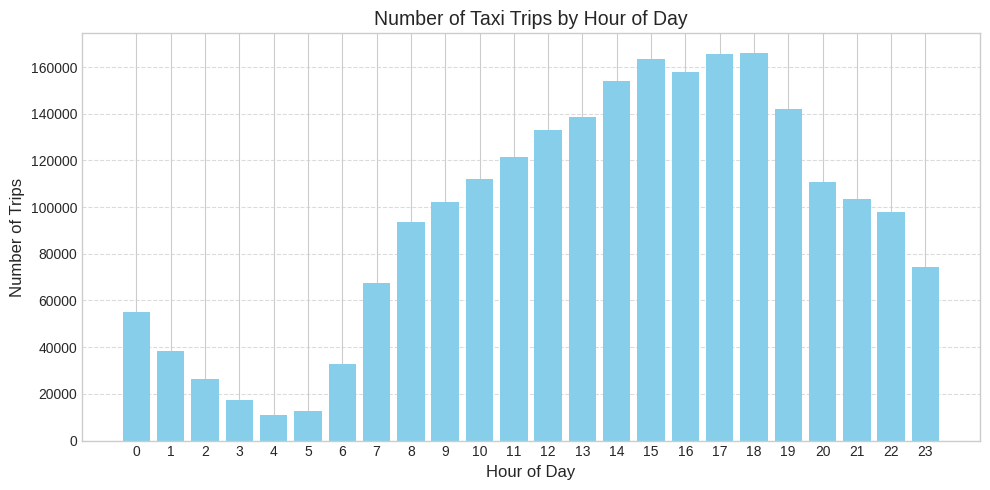

In [20]:
# 1. Trip Count by Hour
hourly_counts = cleaned_df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

plt.figure(figsize=(10, 5))
plt.bar(hourly_counts["pickup_hour"], hourly_counts["count"], color='skyblue')
plt.title("Number of Taxi Trips by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Average Fare by Hour

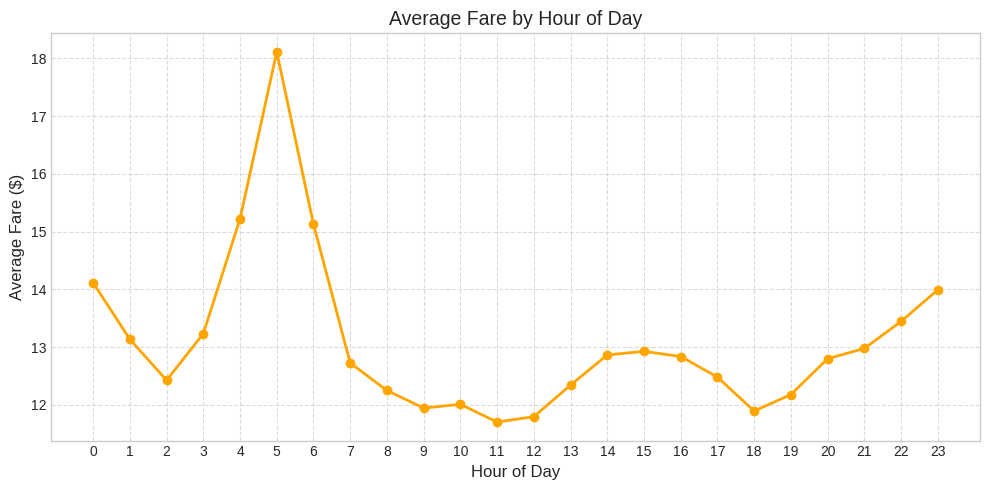

In [21]:
# 2. Average Fare by Hour
hourly_fares = cleaned_df.groupBy("pickup_hour") \
    .agg(F.avg("fare_amount").alias("avg_fare")) \
    .orderBy("pickup_hour") \
    .toPandas()

plt.figure(figsize=(10, 5))
plt.plot(hourly_fares["pickup_hour"], hourly_fares["avg_fare"], 'o-', color='orange', linewidth=2)
plt.title("Average Fare by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Fare ($)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trip Distance Distribution

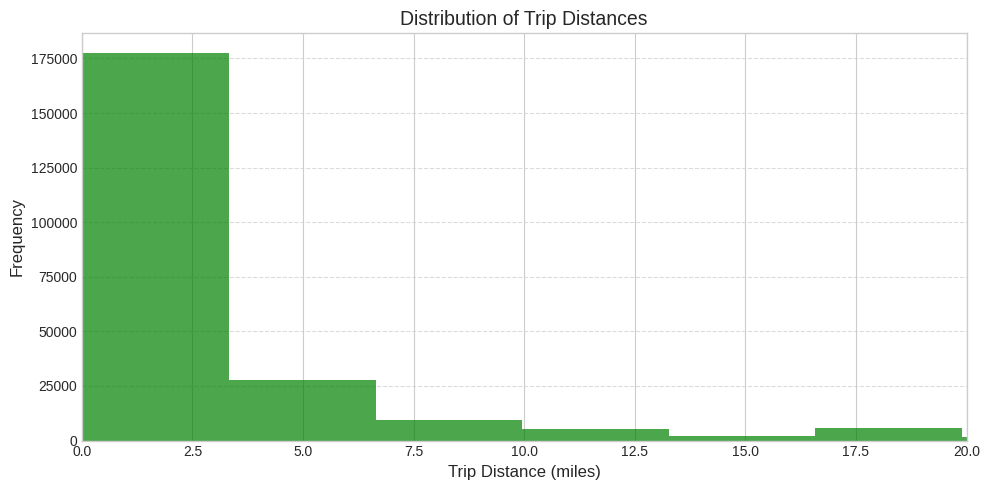

In [22]:
# 3. Trip Distance Distribution
plt.figure(figsize=(10, 5))
plt.hist(sample_df["trip_distance"], bins=30, alpha=0.7, color='green')
plt.title("Distribution of Trip Distances", fontsize=14)
plt.xlabel("Trip Distance (miles)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(0, 20)  # Focus on most common distances
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trip Distance vs. Fare Amount (Scatter Plot)

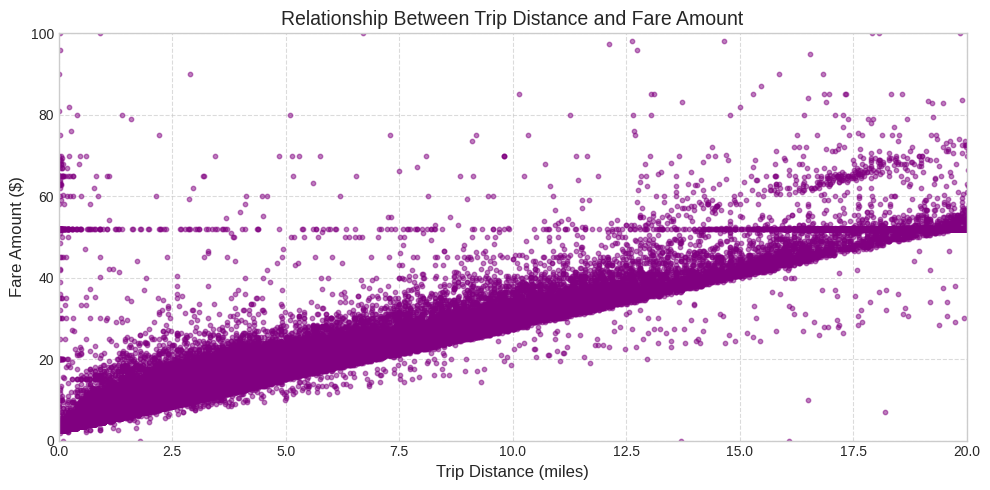

In [23]:
# 4. Trip Distance vs. Fare Amount Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(sample_df["trip_distance"], sample_df["fare_amount"], alpha=0.5, color='purple', s=10)
plt.title("Relationship Between Trip Distance and Fare Amount", fontsize=14)
plt.xlabel("Trip Distance (miles)", fontsize=12)
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.xlim(0, 20)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trip Count vs Tip Percentage

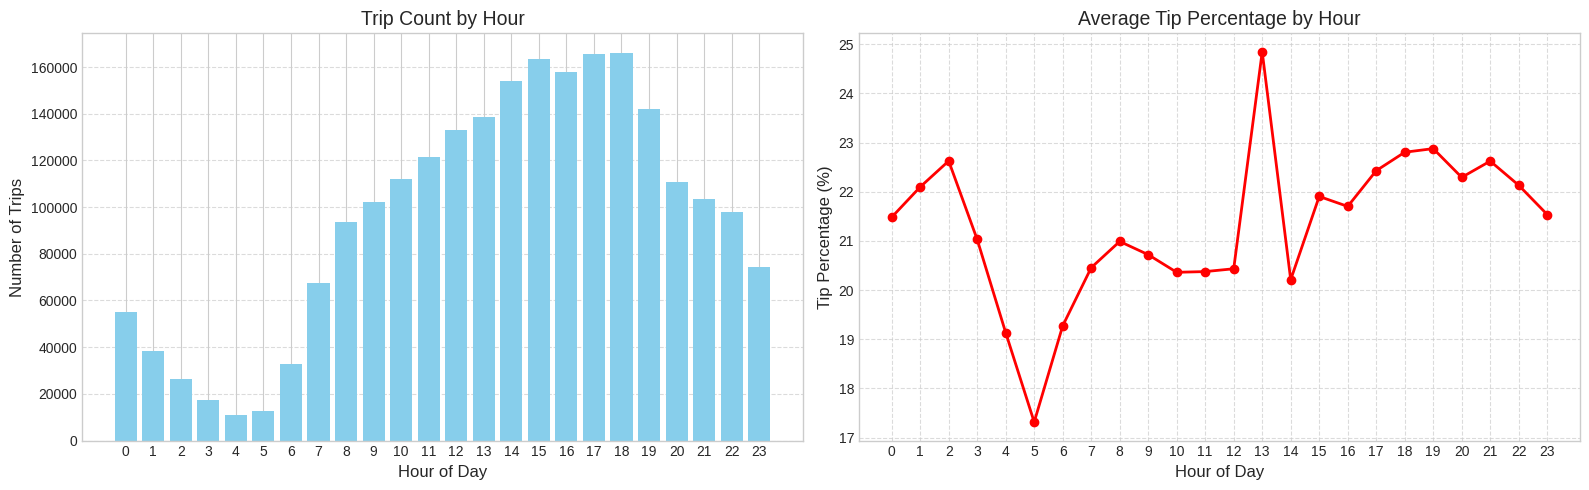

In [26]:
# 6. Side by side comparison of Trip Count and Tip Percentage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left plot - Trip Count
ax1.bar(hourly_counts["pickup_hour"], hourly_counts["count"], color='skyblue')
ax1.set_title("Trip Count by Hour", fontsize=14)
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Number of Trips", fontsize=12)
ax1.set_xticks(range(0, 24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Right plot - Tip Percentage
ax2.plot(hourly_tips["pickup_hour"], hourly_tips["avg_tip_pct"], 'o-', color='red', linewidth=2)
ax2.set_title("Average Tip Percentage by Hour", fontsize=14)
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Tip Percentage (%)", fontsize=12)
ax2.set_xticks(range(0, 24))
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Distribution of Key Metrics

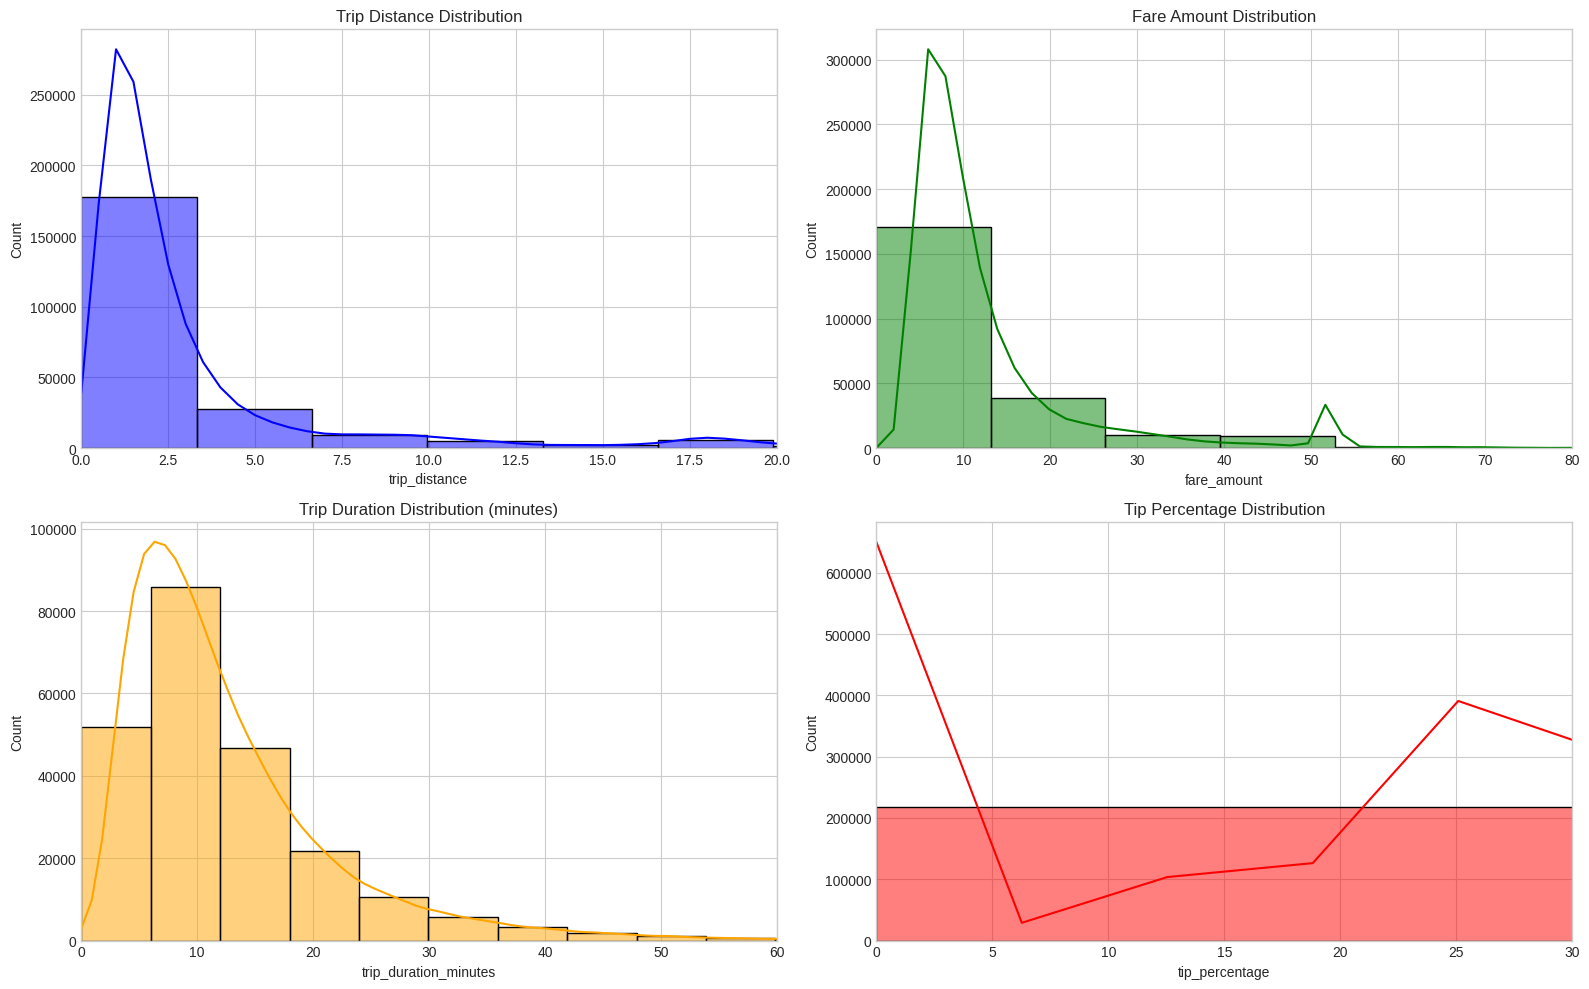

In [27]:
# 7. Multi-panel distribution plots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Trip Distance
sns.histplot(sample_df["trip_distance"], bins=30, kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Trip Distance Distribution')
axs[0, 0].set_xlim(0, 20)

# Fare Amount
sns.histplot(sample_df["fare_amount"], bins=30, kde=True, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Fare Amount Distribution')
axs[0, 1].set_xlim(0, 80)

# Trip Duration
sns.histplot(sample_df["trip_duration_minutes"], bins=30, kde=True, ax=axs[1, 0], color='orange')
axs[1, 0].set_title('Trip Duration Distribution (minutes)')
axs[1, 0].set_xlim(0, 60)

# Tip Percentage
sns.histplot(sample_df["tip_percentage"], bins=30, kde=True, ax=axs[1, 1], color='red')
axs[1, 1].set_title('Tip Percentage Distribution')
axs[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

# Weekday vs. Weekend Comparison

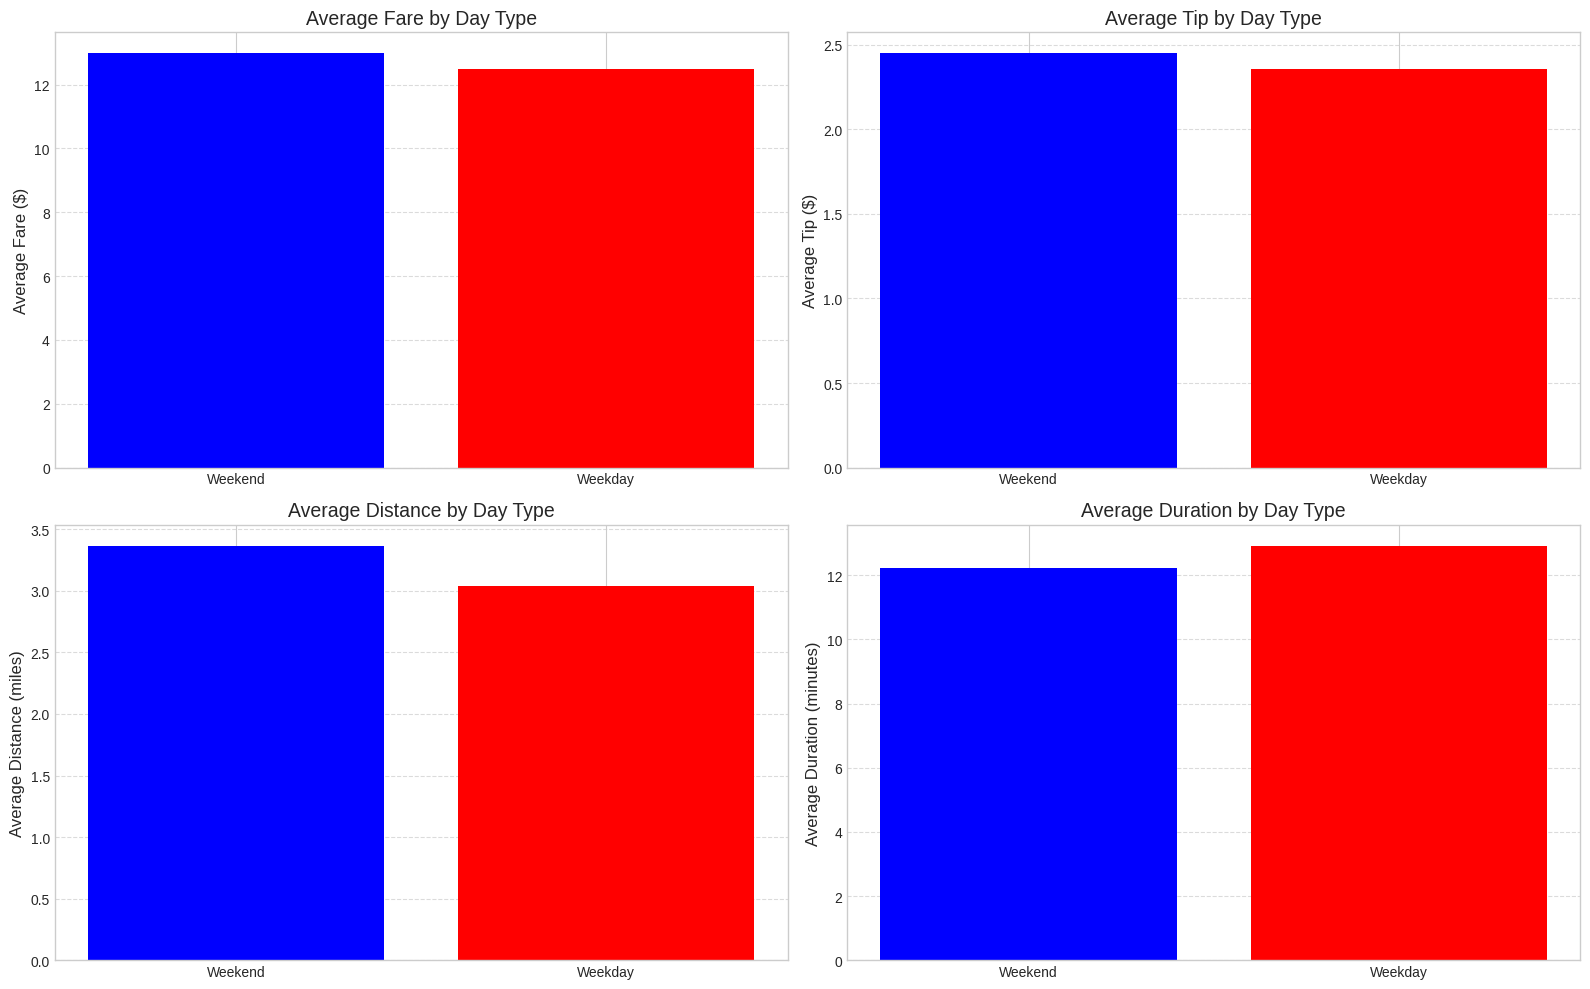

In [28]:
# 8. Weekday vs Weekend comparison
day_type_stats = cleaned_df.groupBy("is_weekend") \
    .agg(
        F.count("*").alias("trip_count"),
        F.avg("fare_amount").alias("avg_fare"),
        F.avg("tip_amount").alias("avg_tip"),
        F.avg("trip_distance").alias("avg_distance"),
        F.avg("trip_duration_minutes").alias("avg_duration")
    ) \
    .toPandas()

# Convert boolean to string for better labels
day_type_stats["day_type"] = day_type_stats["is_weekend"].apply(lambda x: "Weekend" if x else "Weekday")

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Average Fare
axs[0, 0].bar(day_type_stats["day_type"], day_type_stats["avg_fare"], color=['blue', 'red'])
axs[0, 0].set_title('Average Fare by Day Type', fontsize=14)
axs[0, 0].set_ylabel('Average Fare ($)', fontsize=12)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Average Tip
axs[0, 1].bar(day_type_stats["day_type"], day_type_stats["avg_tip"], color=['blue', 'red'])
axs[0, 1].set_title('Average Tip by Day Type', fontsize=14)
axs[0, 1].set_ylabel('Average Tip ($)', fontsize=12)
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Average Distance
axs[1, 0].bar(day_type_stats["day_type"], day_type_stats["avg_distance"], color=['blue', 'red'])
axs[1, 0].set_title('Average Distance by Day Type', fontsize=14)
axs[1, 0].set_ylabel('Average Distance (miles)', fontsize=12)
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Average Duration
axs[1, 1].bar(day_type_stats["day_type"], day_type_stats["avg_duration"], color=['blue', 'red'])
axs[1, 1].set_title('Average Duration by Day Type', fontsize=14)
axs[1, 1].set_ylabel('Average Duration (minutes)', fontsize=12)
axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Correlation Matrix Heatmap

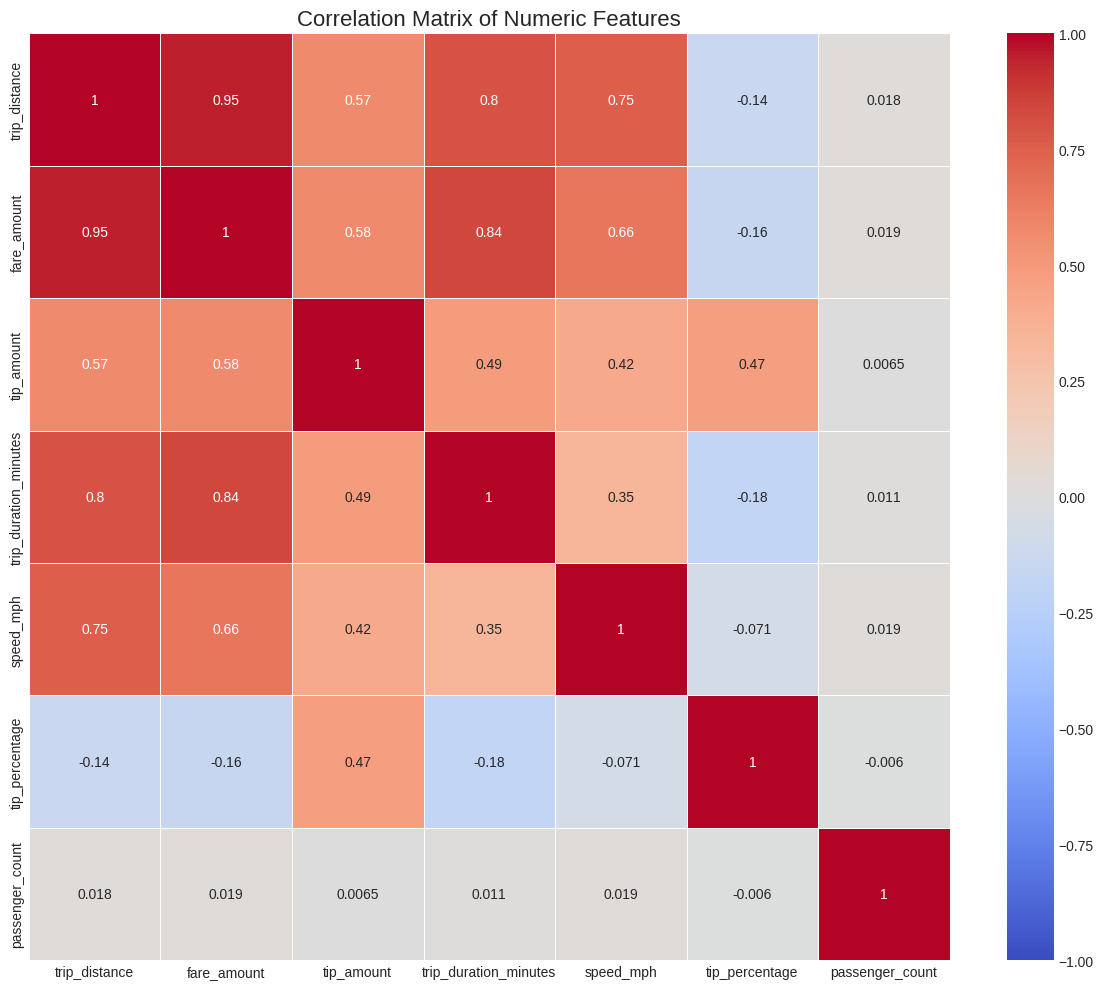

In [29]:
# 9. Correlation matrix heatmap
# Select numeric columns for correlation analysis
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "trip_duration_minutes", 
               "speed_mph", "tip_percentage", "passenger_count"]

# Calculate correlations using pandas
corr_df = sample_df[numeric_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()